In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
import scanpy as sc
import numpy as np 
import pandas as pd
# import anndata as ad
import yaml

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset9/"

# Data Loading

In [5]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 15413 × 45768
    obs: 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'driver_lines', 'reporter_lines', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'injection_label_direction', 'injection_primary', 'injection_secondary', 'injection_tract', 'injection_material', 'injection_exclusion_criterion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'tdt_cpm', 'gfp_cpm', 'class', 'subclass', 'cluster', 'confusion_score', 'cluster_correlation', 'core_intermediate_call'
    

In [6]:
adata_st = sc.read(data_path + "MERFISH_data.h5ad")  # .obsm['spatial'] contains affine coordinates
adata_st

AnnData object with n_obs × n_vars = 2399 × 254
    obs: 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um'
    var: 'gene'
    obsm: 'spatial'

# Config

In [12]:
# Read config yaml
with open("data/Dataset9/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed

{'cluster_label': 'subclass',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

# Train/val split

In [13]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

203 training genes:  ['slc30a3' 'trpc4' 'il4ra' 'tox' 'parm1' 'npy2r' '1700022i11rik' 'pvalb'
 'olfm3' 'ccdc3'] ...
51 validation genes:  ['b4galnt3' 'wnt7b' 'cacng5' 'vipr2' 'prr16' 'ikzf2' 'sulf1' 'cspg4'
 'rgs6' 'c1qtnf7'] ...


# Model training

In [14]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


Trainig:  10%|█         | 100/1000 [34:53<5:14:02, 20.94s/it]


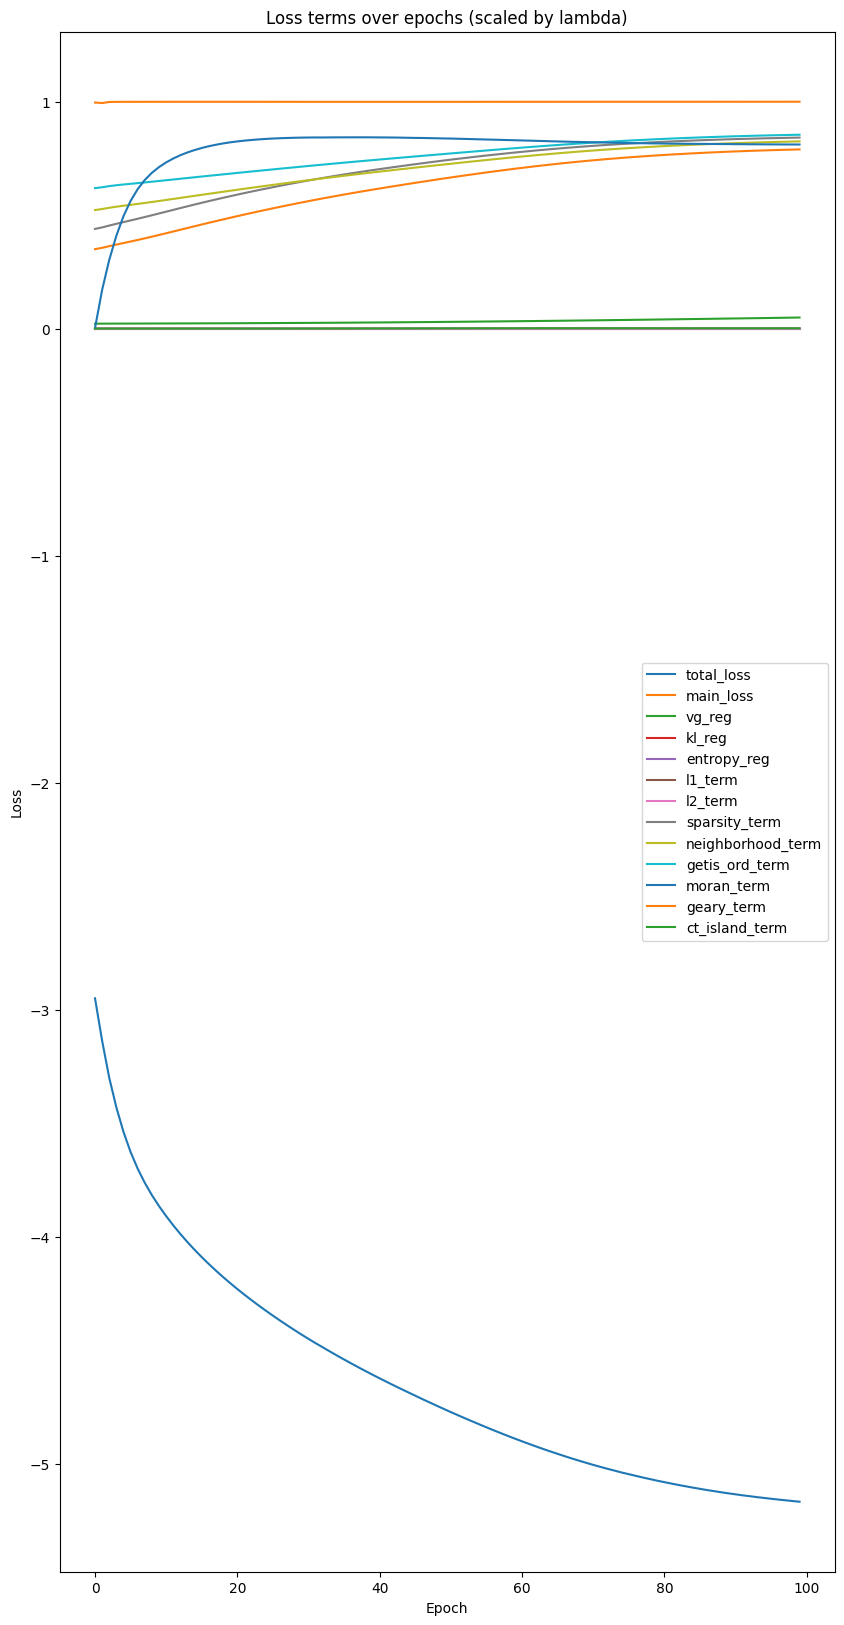

In [17]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True, show_total_loss=False)

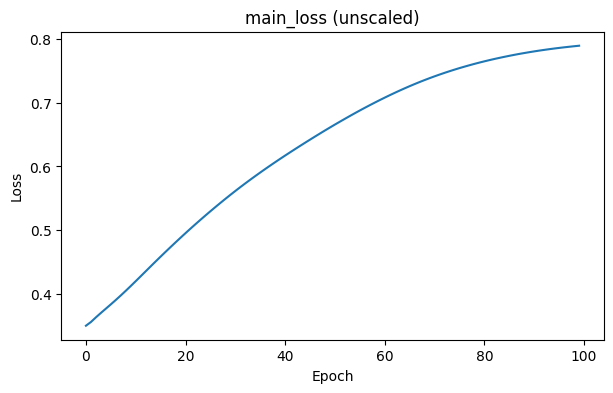

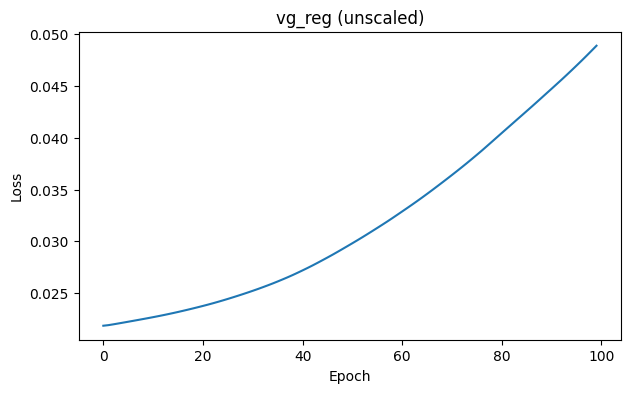

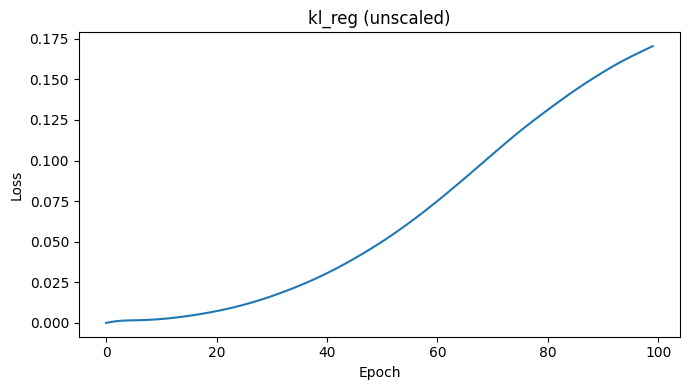

In [18]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

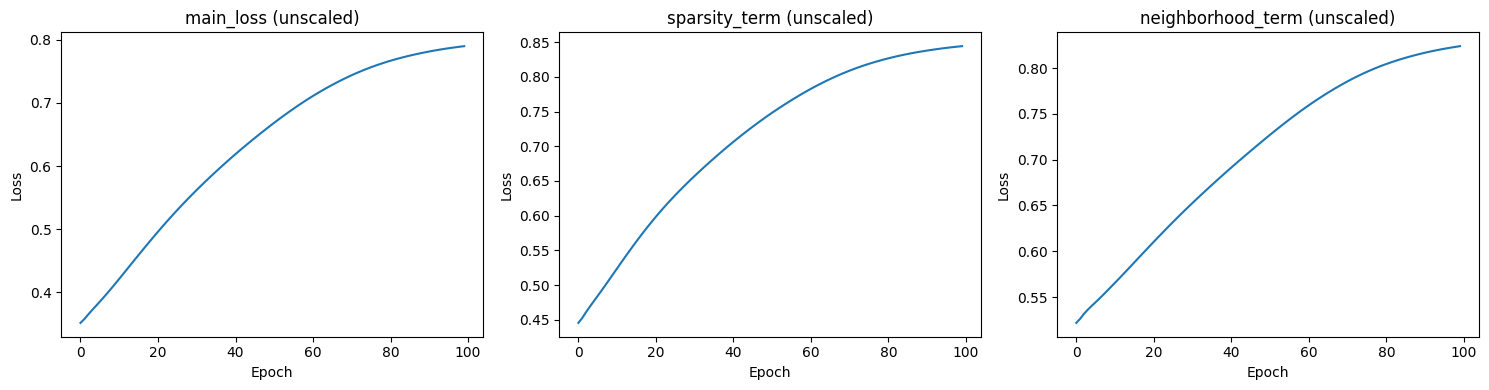

In [39]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

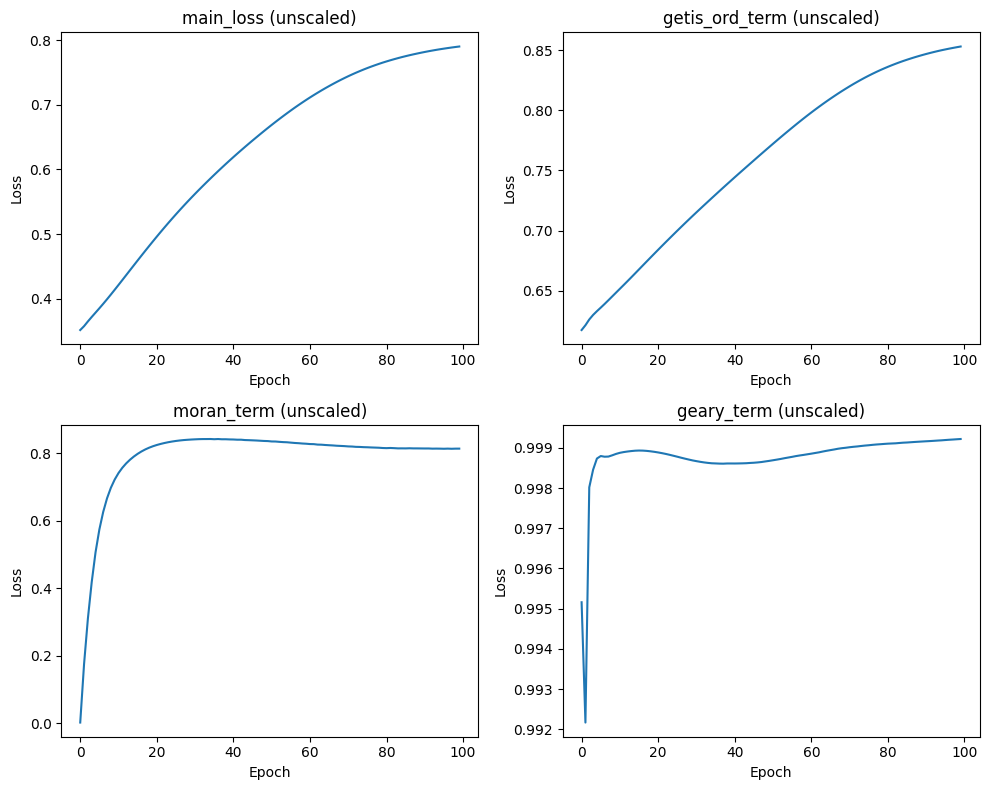

In [42]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

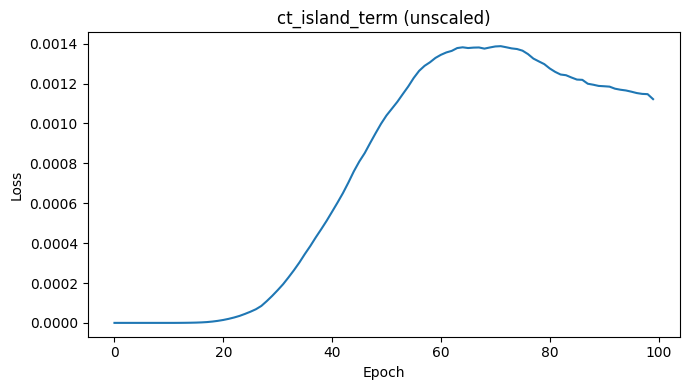

In [43]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

# Validation

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


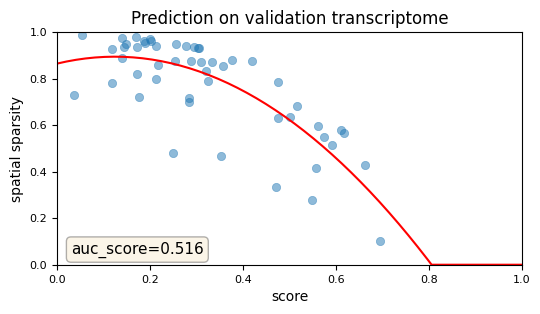

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │      0.516248881816864      │
│           val_JS            │     0.44096431136131287     │
│           val_PCC           │     0.16068382561206818     │
│          val_RMSE           │     1.2922776937484741      │
│          val_SSIM           │     0.13654585182666779     │
│         val_entropy         │     0.3325480818748474      │
│          val_score          │     0.32258927822113037     │
│ val_sparsity-weighted_score │     0.43547049164772034     │
└─────────────────────────────┴─────────────────────────────┘

In [19]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

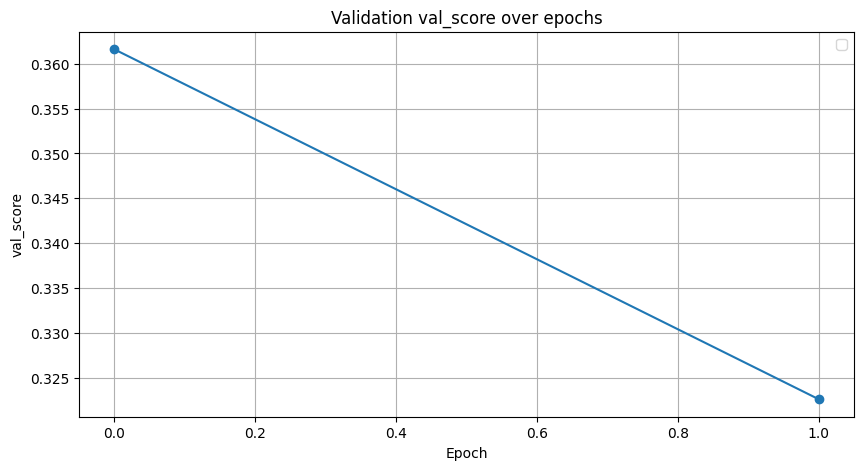

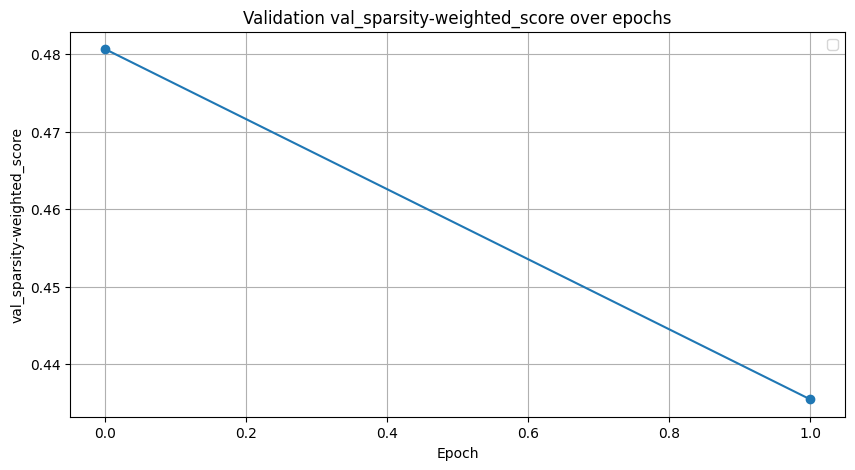

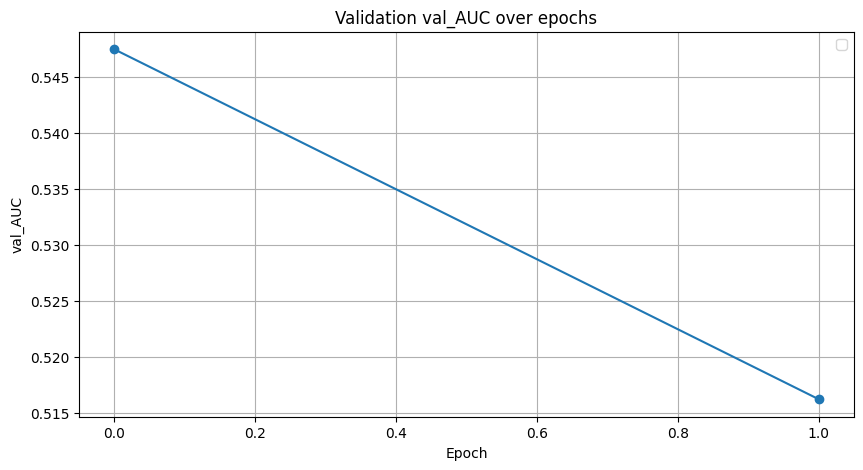

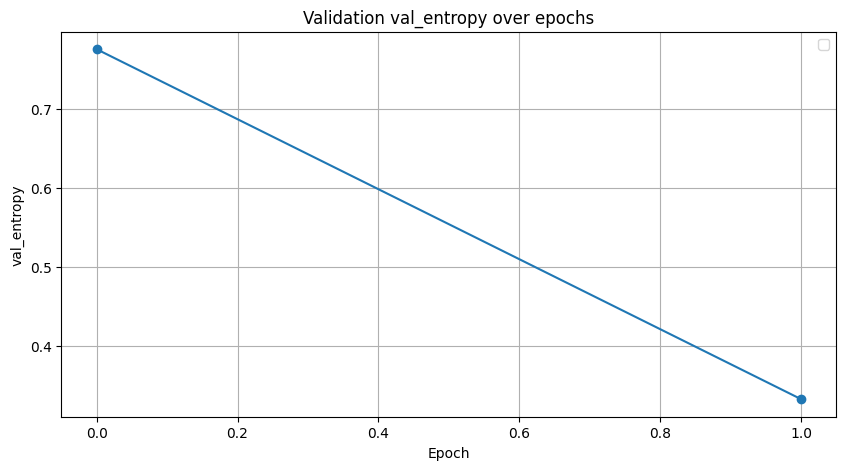

In [20]:
tgl.plot_validation_metrics_history(adata_map=ad_map)

# Sparsity

In [46]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 45768
    obs: 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um'
    var: 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [47]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

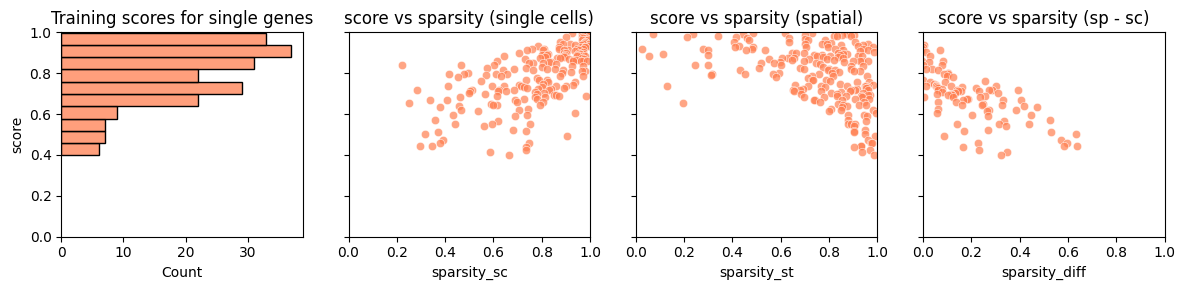

In [48]:
# Plot training scores panels
tgl.plot_training_scores(df)

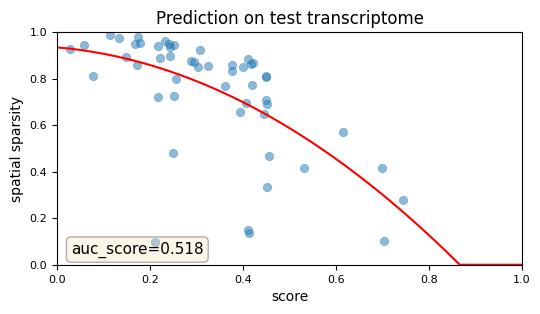

In [49]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [ ]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset9', adata=ad_map, ext='h5ad')

# Optuna

In [21]:
config['num_epochs'] = 50  # decrease for optuna tuning
config

{'cluster_label': 'subclass',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 50,
 'random_state': 42,
 'target_count': None}

In [22]:
study_name = "tangram_tuning_Dataset9_no_filtering"
study_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/Dataset9/"
storage = f"sqlite:///{study_path}{study_name}.db"
n_trials = 20
resume = True

In [24]:
best_params, trials_df = tgl.tune_loss_coefficients(
        adata_sc=adata_sc,
        adata_st=adata_st,
        input_genes=None,
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        study_name=study_name,
        storage=storage,
        n_trials=n_trials,
        timeout=None,
        resume=resume,
        )

[I 2025-11-06 13:31:43,456] A new study created in RDB with name: tangram_tuning_Dataset9_no_filtering
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 13:49:26,614] Trial 0 finished with value: 0.8924779891967773 and parameters: {'lambda_d': 0.0002317926943278792, 'lambda_g2': 0.02863696649731339, 'lambda_r': 1.1359874866936364e-09, 'lambda_l1': 1.322001296854461e-13, 'lambda_l2': 1.3411453545370151e-20, 'lambda_neighborhood_g1': 2.567568783382027, 'lambda_getis_ord': 0.26404619086204684, 'lambda_moran': 1.9221040806316398, 'lambda_geary': 3.618671089650746, 'lambda_ct_islands': 0.03715885756422631}. Best is trial 0 with value: 0.8924779891967773.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainabl


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 13:51:02,483] Trial 1 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 14:08:45,429] Trial 2 finished with value: 0.8874000310897827 and parameters: {'lambda_d': 3.004972069784512e-05, 'lambda_g2': 0.011693114251881217, 'lambda_r': 7.75427312173871e-05, 'lambda_l1': 1.5740018778389055e-14, 'lambda_l2': 4.6484247145031814e-20, 'lambda_neighborhood_g1': 0.013650841035344691, 'lambda_getis_ord': 0.017076822175562688, 'lambda_moran': 0.014516924324228566, 'lambda_geary': 1.659651085542681, 'lambda_ct_islands': 0.28032074159773707}. Best is trial 0 with value: 0.8924779891967773.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-tr


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 14:10:21,598] Trial 3 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 14:28:06,359] Trial 4 finished with value: 0.9214198589324951 and parameters: {'lambda_d': 1.4419043625841247e-05, 'lambda_g2': 0.04201991581185463, 'lambda_r': 2.5093240560775563e-06, 'lambda_l1': 3.890789082315502e-15, 'lambda_l2': 8.505317148880422e-16, 'lambda_neighborhood_g1': 0.11338065571223753, 'lambda_getis_ord': 7.376555054819507, 'lambda_moran': 0.03734899149914691, 'lambda_geary': 3.709401972512767, 'lambda_ct_islands': 0.01751123735948948}. Best is trial 4 with value: 0.9214198589324951.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainab


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 14:45:47,089] Trial 5 finished with value: 0.9165699481964111 and parameters: {'lambda_d': 7.509581998829345e-06, 'lambda_g2': 0.11948360261825858, 'lambda_r': 1.0920548337017086e-05, 'lambda_l1': 2.6543824694232747e-15, 'lambda_l2': 8.498203661155646e-16, 'lambda_neighborhood_g1': 0.5998554137781609, 'lambda_getis_ord': 4.153766091650971, 'lambda_moran': 0.1463593342296313, 'lambda_geary': 2.25130156697237, 'lambda_ct_islands': 0.04348027067254601}. Best is trial 4 with value: 0.9214198589324951.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable 


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 15:03:26,557] Trial 6 finished with value: 0.9320763945579529 and parameters: {'lambda_d': 1.7642223058556263e-05, 'lambda_g2': 0.031085342969036703, 'lambda_r': 4.051929632244344e-09, 'lambda_l1': 9.75110005654244e-16, 'lambda_l2': 4.4438864817832233e-13, 'lambda_neighborhood_g1': 0.9535704075192497, 'lambda_getis_ord': 3.4747241849480064, 'lambda_moran': 0.022197504786532853, 'lambda_geary': 0.5714464221505794, 'lambda_ct_islands': 0.010031623086003869}. Best is trial 6 with value: 0.9320763945579529.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trai


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 15:21:04,663] Trial 7 finished with value: 0.932058572769165 and parameters: {'lambda_d': 3.253783948322527e-05, 'lambda_g2': 0.02621847131507391, 'lambda_r': 3.626731900749814e-10, 'lambda_l1': 1.9982284226642053e-17, 'lambda_l2': 7.691764618423386e-13, 'lambda_neighborhood_g1': 1.5338713640581165, 'lambda_getis_ord': 1.372578629865873, 'lambda_moran': 0.08223168383846426, 'lambda_geary': 0.036596607159008504, 'lambda_ct_islands': 0.025076037558732223}. Best is trial 6 with value: 0.9320763945579529.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-traina


Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:24:04,582] Trial 8 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:27:04,379] Trial 9 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:30:04,584] Trial 10 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:33:05,246] Trial 11 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:34:41,353] Trial 12 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:41:53,426] Trial 13 pruned. Trial was pruned at epoch 19.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:43:29,852] Trial 14 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:45:05,905] Trial 15 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:46:41,897] Trial 16 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:48:18,665] Trial 17 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


[I 2025-11-06 15:49:54,606] Trial 18 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 16:07:34,024] Trial 19 finished with value: 0.9326971769332886 and parameters: {'lambda_d': 1.260484230026874e-06, 'lambda_g2': 0.06706024933480799, 'lambda_r': 1.7683752243984927e-10, 'lambda_l1': 3.392757963923039e-17, 'lambda_l2': 2.3121357777866227e-13, 'lambda_neighborhood_g1': 0.5788769072911655, 'lambda_getis_ord': 2.4155255635496964, 'lambda_moran': 0.015965800161727762, 'lambda_geary': 0.5263349718942099, 'lambda_ct_islands': 0.020337349808201823}. Best is trial 19 with value: 0.9326971769332886.


Best trial:
  Value: 0.9326971769332886
  Params:
    lambda_d: 1.260484230026874e-06
    lambda_g2: 0.06706024933480799
    lambda_r: 1.7683752243984927e-10
    lambda_l1: 3.392757963923039e-17
    lambda_l2: 2.3121357777866227e-13
    lambda_neighborhood_g1: 0.5788769072911655
    lambda_getis_ord: 2.4155255635496964
    lambda_moran: 0.015965800161727762
    lambda_geary: 0.5263349718942099
    lambda_ct_islands: 0.020337349808201823


In [28]:
study = optuna.load_study(study_name=study_name, storage=storage)

In [29]:
import optuna as optuna
optuna.visualization.plot_timeline(study)


In [32]:
optuna.visualization.plot_optimization_history(study)


In [33]:
optuna.visualization.plot_param_importances(study)

In [34]:
optuna.visualization.plot_intermediate_values(study)